# Lung Mask Segmentation With U-Net (Covid CT-scan dataset)

## Retrieveing the datset from Kaggle

In [1]:
from google.colab import files
token=files.upload()

Saving kaggle (3).json to kaggle (3).json


In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install kaggle

In [6]:
!kaggle datasets download -d andrewmvd/covid19-ct-scans

 98% 1.02G/1.03G [00:08<00:00, 138MB/s]
100% 1.03G/1.03G [00:08<00:00, 128MB/s]


In [7]:
!unzip -q covid19-ct-scans.zip

In [ ]:
!pip install keras-segmentation

In [ ]:
!pip install -U segmentation-models

In [10]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.7.0
GPU is available


In [11]:
metadata = pd.read_csv('/content/metadata.csv')
metadata.replace('../input/covid19-ct-scans/', '/content/', regex=True, inplace=True)
print(metadata.shape)
metadata.head()

(20, 4)


ct_scan  ...                            lung_and_infection_mask
0  /content/ct_scans/coronacases_org_001.nii  ...  /content/lung_and_infection_mask/coronacases_0...
1  /content/ct_scans/coronacases_org_002.nii  ...  /content/lung_and_infection_mask/coronacases_0...
2  /content/ct_scans/coronacases_org_003.nii  ...  /content/lung_and_infection_mask/coronacases_0...
3  /content/ct_scans/coronacases_org_004.nii  ...  /content/lung_and_infection_mask/coronacases_0...
4  /content/ct_scans/coronacases_org_005.nii  ...  /content/lung_and_infection_mask/coronacases_0...

[5 rows x 4 columns]

In [12]:
# img_size is the preferred image size to which the image is to be resized
img_size = 512

In [13]:
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  301


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


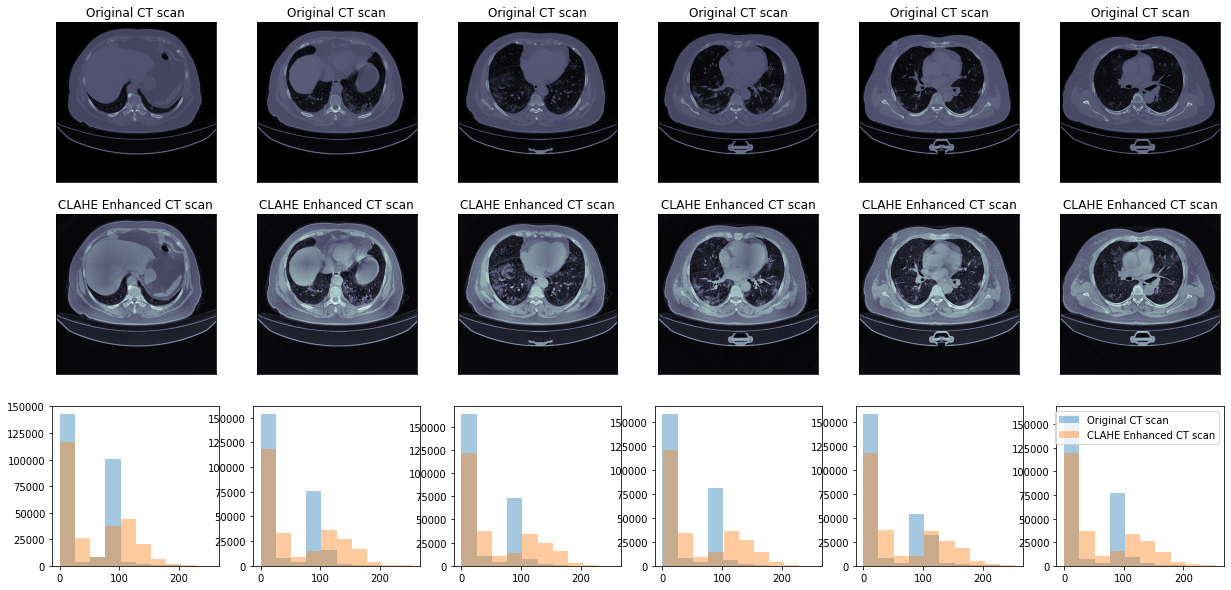

In [14]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [15]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    #Areas = [cv.contourArea(cc) for cc in contours]; print(Areas)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    #plt.figure() # uncomment to troubleshoot
    #canvas = np.zeros_like(img)
    #cv.drawContours(canvas , contours, -1, (255, 255, 0), 1)
    #plt.imshow(canvas)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

Number of slices:  301


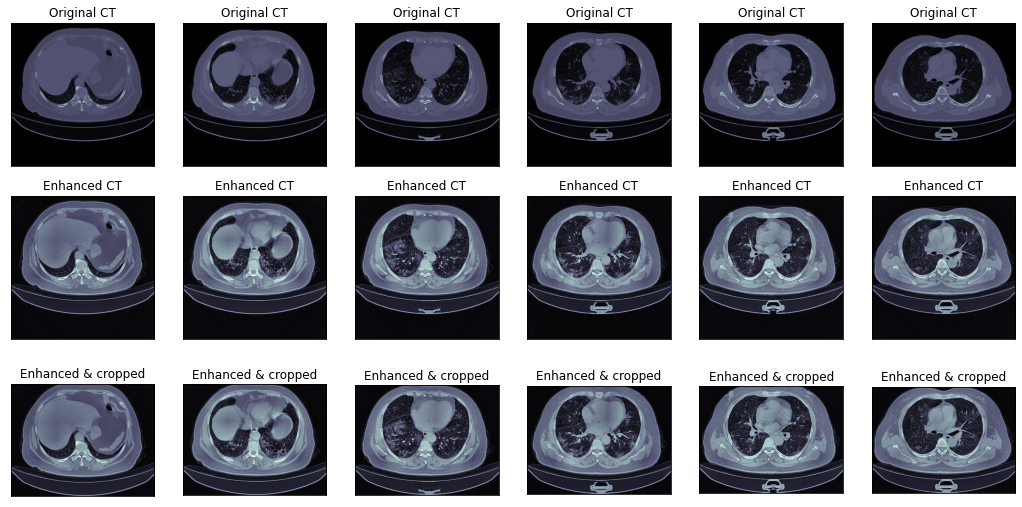

In [16]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

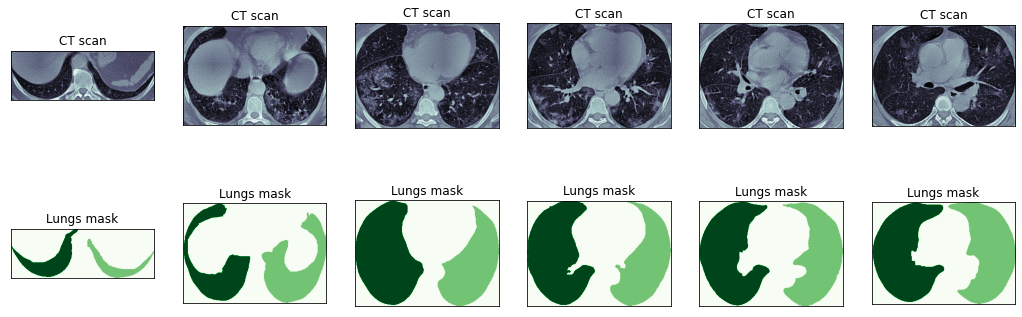

In [17]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
#infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
#arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
#arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
#arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
#arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                    # (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(2, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
   # img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    #cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    #axes[2,ii].imshow(cropped_infec, cmap='Reds')
    #axes[2,ii].set_title("Infection mask")
    #axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

In [18]:
cts_all = []
lungs_all = []
#infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    #infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    #arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    #arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    #arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    #arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                    # (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1)
    
    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size),interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

       # img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
        #                      interpolation=cv.INTER_AREA)
        #cropped_infec = crop_(img_infec, bounds)
        #infects_all.append(cropped_infec)

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [19]:
print(len(cts_all))

2112


In [20]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        #infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        #infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    #del infects_all[idx]

100%|██████████| 2112/2112 [00:02<00:00, 1026.84it/s]


Text(0.5, 1.0, 'Lungs')

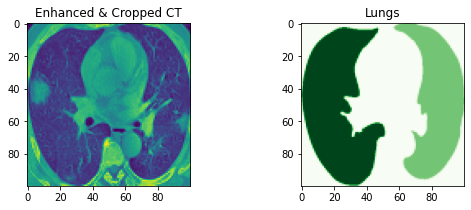

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

#axes[2].imshow(infects_all[250][:, :, 0], cmap='Reds')
#axes[2].set_title("Infection");

In [22]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all}, myfile)

In [23]:
lung_bool = np.ones((1, len(lungs_all)))
for ii in range(len(lungs_all)):
    if np.unique(lungs_all[ii]).size == 1:
        lung_bool[0, ii] = 0
        
print("Number of CTs with no lung mask: %d" %(len(lungs_all)-lung_bool.sum()))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no lung mask: 0


In [24]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [25]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
sample_lungs = [lungs_all[ii] for ii in rand_idx]
#sample_infects = [infects_all[ii] for ii in rand_idx]

In [26]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
lungs_aug = seq_det.augment_images(sample_lungs)
#infects_aug = seq_det.augment_images(sample_infects)

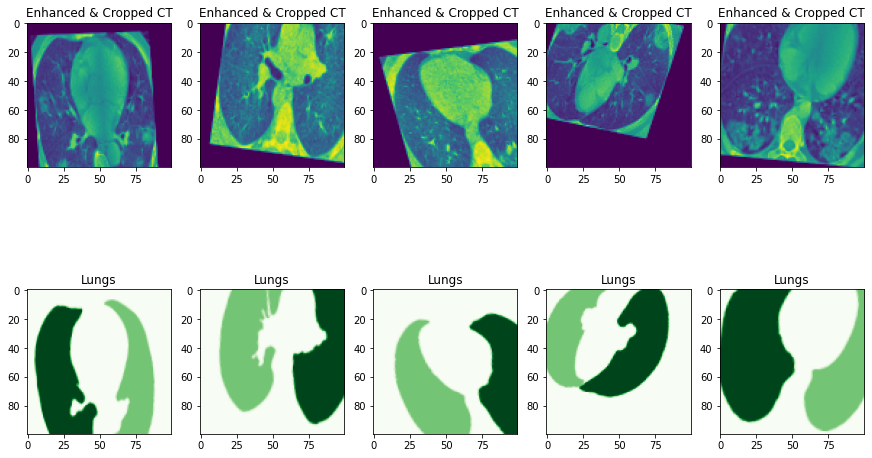

In [27]:
fig, axes = plt.subplots(2, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    axes[1, ii].set_title("Lungs")

    #axes[2, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    #axes[2, ii].set_title("Infection");

In [28]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
lungs_all = tf.convert_to_tensor(lungs_all)
lungs_aug = tf.convert_to_tensor(lungs_aug)
#infects_all = tf.convert_to_tensor(infects_all)
#infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
lungs = tf.concat([lungs_all, lungs_aug], axis=0)
#infects = tf.concat([infects_all, infects_aug], axis=0)

In [29]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
lungs = tf.gather(lungs, shuffled_indices)
#infects = tf.gather(infects, shuffled_indices)

print(cts.shape, lungs.shape)

(3157, 100, 100, 1) (3157, 100, 100, 1)


In [30]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'lungs': lungs}, myfile)

In [31]:
## see https://github.com/keras-team/keras/issues/9395

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) 
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [32]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [33]:
# define learning rate callback
n_epochs = 200
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

In [34]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x) 
    
    return x

In [35]:
def cts_model (input_shape) :
    
    x_input = Input(input_shape)
    
    ##################################  LUNG SEGMENTATION  ######################
    x, x1 = cts_block_1 (x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25

    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    lung_seg = Conv2D(1, (1, 1), activation='sigmoid', name='lung_output') (x) #x: 100x100

    ##################################  INFECTION SEGMENTATION  ######################
    
   
    model = Model(inputs=x_input, outputs=[lung_seg], name='cts_model')
    
    return model

In [36]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 32  9248        ['conv2d[0][0]']                 
                                )                                                         

In [37]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yl_train = (cts[:train_size]/255, 
                               lungs[:train_size]) 
                               

X_valid, yl_valid = (cts[train_size:train_size+test_size]/255, 
                               lungs[train_size:train_size+test_size])
                             

X_test, yl_test = (cts[train_size+test_size:]/255, 
                            lungs[train_size+test_size:])
                           

print(X_train.shape, yl_train.shape)
print(X_test.shape, yl_test.shape)

(2525, 100, 100, 1) (2525, 100, 100, 1)
(317, 100, 100, 1) (317, 100, 100, 1)


In [38]:
batch_size = 128
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

In [39]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras

optim = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = {'lung_output': bce_dice_loss}
loss_weight_dict = {'lung_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={'lung_output': yl_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'lung_output': yl_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])

Epoch 1/200
20/20 [==============================] - 23s 486ms/step - loss: 0.3747 - dice_coeff: 0.6953 - val_loss: 27.4743 - val_dice_coeff: 0.0086
Epoch 2/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2636 - dice_coeff: 0.7789 - val_loss: 2.7758 - val_dice_coeff: 0.1549
Epoch 3/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2406 - dice_coeff: 0.7920 - val_loss: 1.6097 - val_dice_coeff: 0.4136
Epoch 4/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2284 - dice_coeff: 0.7990 - val_loss: 1.1823 - val_dice_coeff: 0.3810
Epoch 5/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2226 - dice_coeff: 0.8024 - val_loss: 1.5376 - val_dice_coeff: 0.2989
Epoch 6/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2193 - dice_coeff: 0.8053 - val_loss: 1.3712 - val_dice_coeff: 0.3184
Epoch 7/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2152 - dice_coeff: 0.8078 - val_loss: 0

In [41]:
ctsModel.save('Covid_CT_model.h5')

In [42]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-lungs.json', 'w') as myfile:
     myfile.write(ctsModel_json)

In [43]:
yl_pred = ctsModel.predict(X_test)
print(yl_pred.shape)

(317, 100, 100, 1)


In [44]:
len(X_test)

317

In [45]:
score = ctsModel.evaluate(X_test, yl_test, verbose=2)
print("Dice Loss, Dice Coefficient:", score)

10/10 - 1s - loss: 0.1849 - dice_coeff: 0.8301 - 578ms/epoch - 58ms/step
Dice Loss, Dice Coefficient: [0.18487666547298431, 0.8301084637641907]


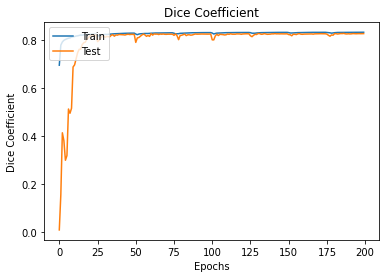

In [46]:
plt.plot(ctsRes.history['dice_coeff'])
plt.plot(ctsRes.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

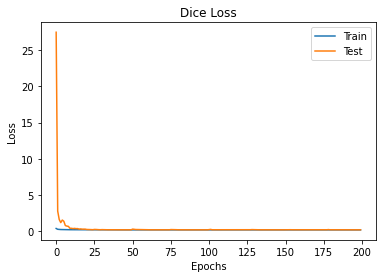

In [47]:
plt.plot(ctsRes.history['loss'])
plt.plot(ctsRes.history['val_loss'])
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [49]:
# Restore the weights
ctsModel.load_weights('/content/Covid_CT_model.h5')

# Evaluate the model
loss, acc =ctsModel.evaluate(X_test, yl_test, verbose=2)
print("Restored model, Dice Coefficient: {:5.2f}%".format(100 * acc))

10/10 - 0s - loss: 0.1849 - dice_coeff: 0.8301 - 290ms/epoch - 29ms/step
Restored model, Dice Coefficient: 83.01%


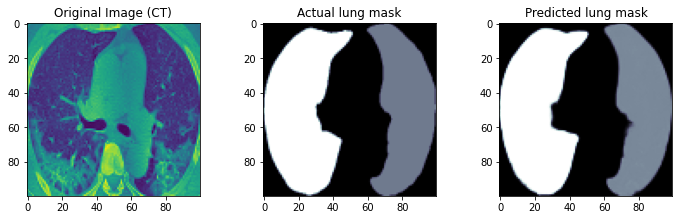

In [50]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))
    for i in range(len(X_test)):
        plt.subplot(2,3,1)
        plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
        plt.title('Original Image (CT)')

        plt.subplot(2,3,2)
        plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('Actual lung mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

        plt.subplot(2,3,3)
        plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('Predicted lung mask')
 
    

   # plt.subplot(2,3,6)
   # plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('predicted infection mask')
    

compare_actual_and_predicted(165)

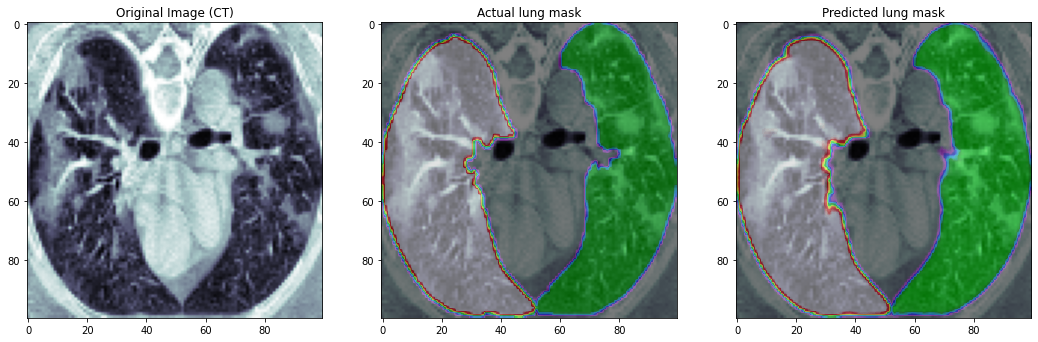

In [51]:
predicted = ctsModel.predict(X_test)
fig = plt.figure(figsize = (18,15))


for i in range(len(X_test)):
    plt.subplot(1,3,1)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(yl_test[i][...,0],alpha = 0.5, cmap = "nipy_spectral")
    plt.title('Actual lung mask')

    plt.subplot(1,3,3)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(predicted[i][...,0],alpha = 0.5,cmap = "nipy_spectral")
    plt.title('Predicted lung mask')

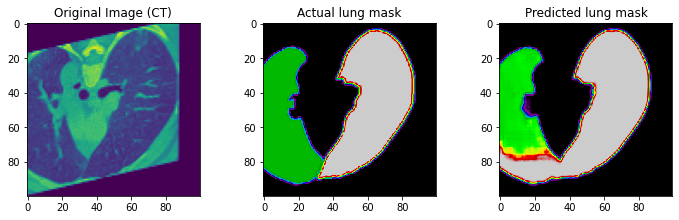

In [52]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('Original Image (CT)')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('Actual lung mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('Predicted lung mask')

   # plt.subplot(2,3,6)
   # plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('predicted infection mask')
    

compare_actual_and_predicted(40)

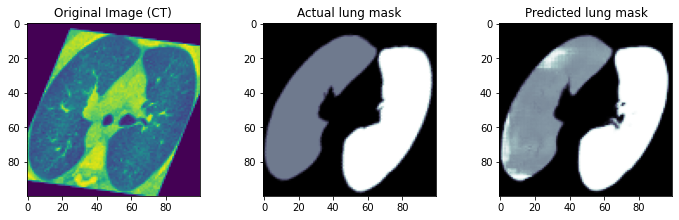

In [53]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,7))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('Original Image (CT)')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yl_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Actual lung mask')

    

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yl_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Predicted lung mask')

   
    

compare_actual_and_predicted(200)

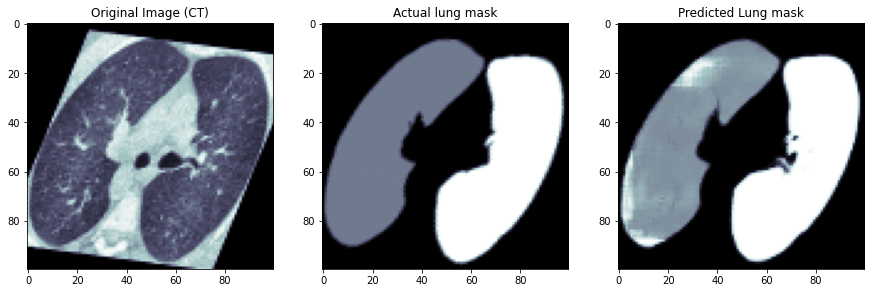

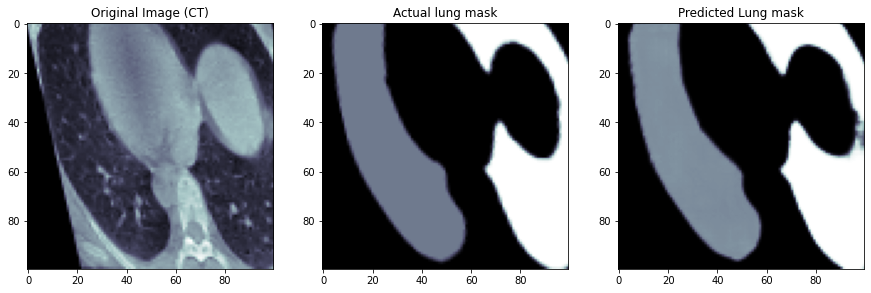

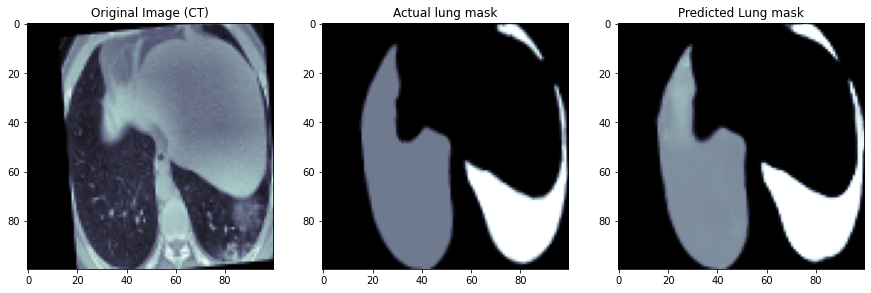

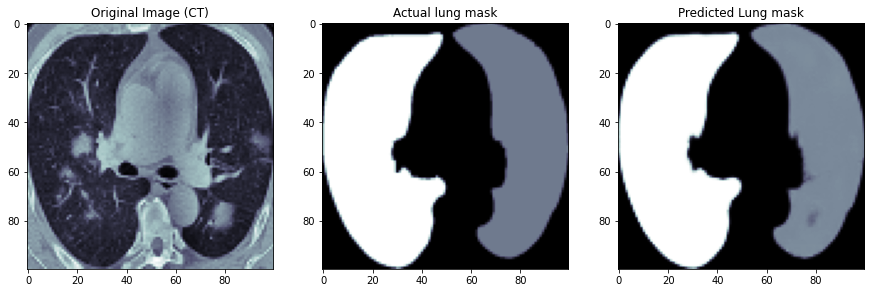

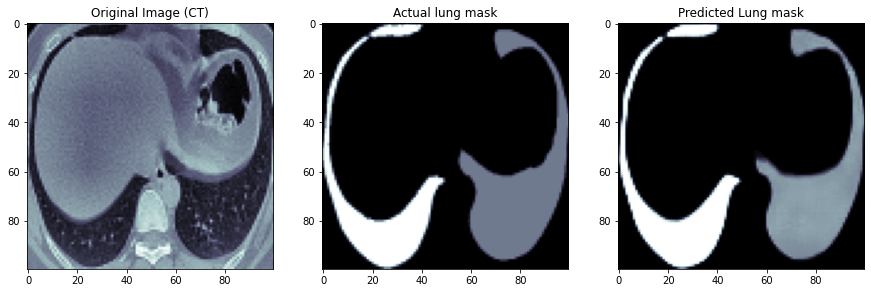

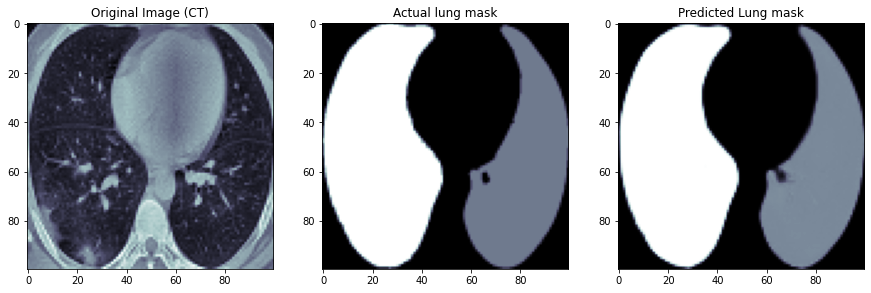

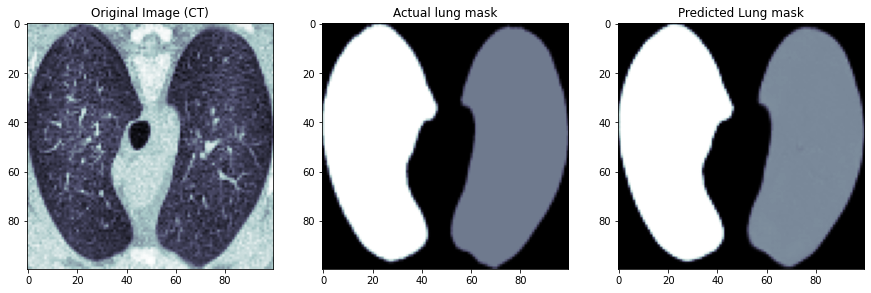

In [54]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def compare_actual_and_predicted(img_num):
    temp = ctsModel.predict(X_test[img_num].reshape(1,num_pix, num_pix,1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(X_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(yl_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Actual lung mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(num_pix, num_pix), cmap='bone')
    plt.title('Predicted Lung mask')

    plt.show()
for i in [200,269,155, 255, 80, 90,51]:
    compare_actual_and_predicted(i)  

In [55]:
the_range = np.arange(0.10,0.80, 0.05)

In [56]:
import segmentation_models as sm

dices=[]
ious=[]

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32) #X_test, yl_test
    dices.append(score[1])
    ious.append(score[2])

Segmentation Models: using `keras` framework.
10/10 [==============================] - 1s 26ms/step - loss: 0.1849 - f1-score: 0.8054 - iou_score: 0.6742


In [57]:
#print('DICES:',dices)
#print("IOUS:",ious)
#print("Best Threshold:", the_range[np.argmax(dices)])
#print("Best dice score:", dices[np.argmax(dices)])
#print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8501266241073608, 0.8528262376785278, 0.8545032739639282, 0.8555912971496582, 0.8563229441642761, 0.8568035364151001, 0.8570682406425476, 0.8571045994758606, 0.8568087816238403, 0.8327018022537231, 0.8131383657455444, 0.8092371225357056, 0.8072010278701782, 0.8053836822509766]
IOUS: [0.7393361330032349, 0.7434283494949341, 0.745980441570282, 0.7476398348808289, 0.7487574815750122, 0.7494925260543823, 0.7498975396156311, 0.7499531507492065, 0.7495006322860718, 0.7133763432502747, 0.6851522326469421, 0.6796377301216125, 0.6767739057540894, 0.6742258667945862]
Best Threshold: 0.45000000000000007
Best dice score: 0.8571045994758606
Best iou score: 0.7499531507492065


In [60]:
metrics = {'Dices': dices, 'IoUs': ious}
df = pd.DataFrame(data=metrics)
df

Dices      IoUs
0   0.850127  0.739336
1   0.852826  0.743428
2   0.854503  0.745980
3   0.855591  0.747640
4   0.856323  0.748757
5   0.856804  0.749493
6   0.857068  0.749898
7   0.857105  0.749953
8   0.856809  0.749501
9   0.832702  0.713376
10  0.813138  0.685152
11  0.809237  0.679638
12  0.807201  0.676774
13  0.805384  0.674226

In [61]:
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

Best Threshold: 0.45000000000000007
Best dice score: 0.8571045994758606
Best iou score: 0.7499531507492065


Best Threshold: 0.45000000000000007


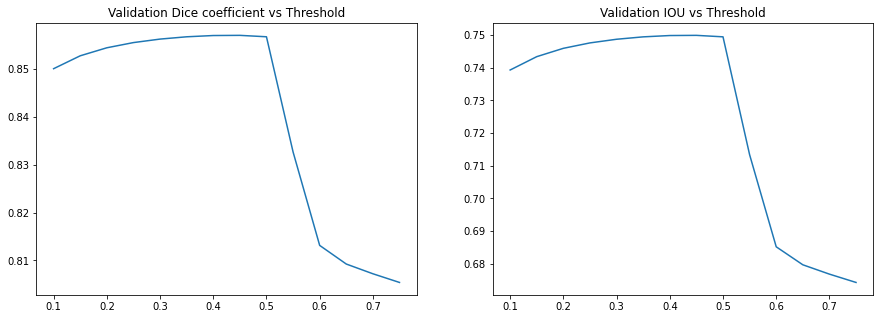

In [62]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [63]:
the_new_range = np.arange(0.43,0.53, 0.001)

In [64]:
new_dices=[]
new_ious=[]

for t in the_new_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32)
    new_dices.append(score[1])
    new_ious.append(score[2])

10/10 [==============================] - 1s 26ms/step - loss: 0.1849 - f1-score: 0.8562 - iou_score: 0.7485


In [66]:
new_metrics = {'New Dices': new_dices, 'NewIoUs': new_ious}
new_df = pd.DataFrame(data=new_metrics)
new_df

New Dices   NewIoUs
0     0.857117  0.749973
1     0.857115  0.749970
2     0.857117  0.749972
3     0.857117  0.749973
4     0.857116  0.749971
..         ...       ...
96    0.856302  0.748725
97    0.856270  0.748677
98    0.856234  0.748621
99    0.856194  0.748561
100   0.856152  0.748497

[101 rows x 2 columns]

In [67]:
print("Best new Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

Best new Threshold: 0.433
Best new dice score: 0.8571173548698425
Best new iou score: 0.7499728202819824


Best Threshold: 0.433


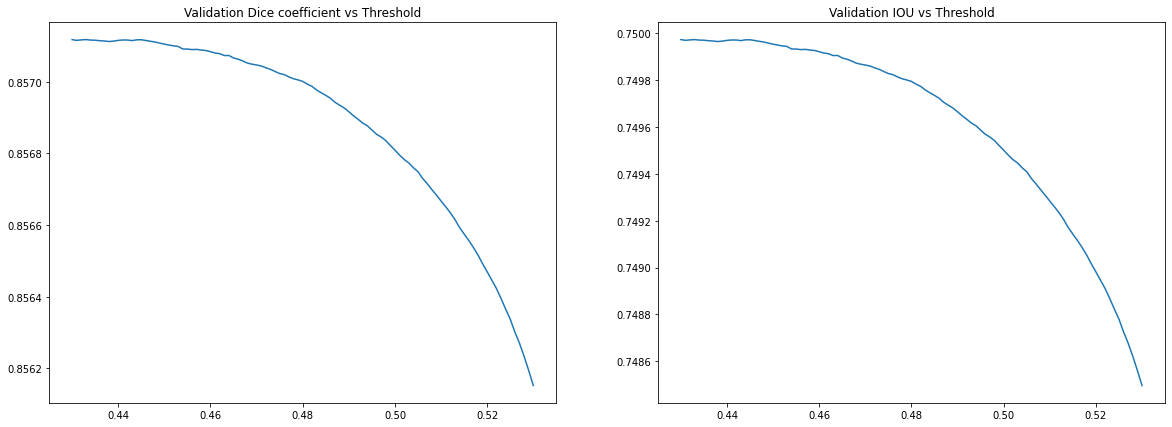

In [68]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [69]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [70]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
    precision = sm.metrics.Precision(threshold=t)
    recall = sm.metrics.Recall(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[precision, recall])
    score = ctsModel.evaluate(X_test, yl_test, batch_size=32)
    precisions.append(score[1])
    recalls.append(score[2])

10/10 [==============================] - 1s 26ms/step - loss: 0.1849 - precision: 0.9921 - recall: 0.6590


In [71]:
F = {'Precisions': precisions, 'Recalls': recalls}
F_df=pd.DataFrame(data=F)
F_df

Precisions   Recalls
0     0.379914  1.000000
1     0.734183  0.995351
2     0.743559  0.992383
3     0.749298  0.989579
4     0.753487  0.986830
5     0.756778  0.984113
6     0.759611  0.981284
7     0.762151  0.978328
8     0.764637  0.974946
9     0.767209  0.970890
10    0.770362  0.965136
11    0.867138  0.801076
12    0.958925  0.705973
13    0.972969  0.692773
14    0.978404  0.687088
15    0.981558  0.682922
16    0.984214  0.678932
17    0.986640  0.674441
18    0.989215  0.668538
19    0.992139  0.659002

In [72]:
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.9921387434005737
Best recall score: 1.0


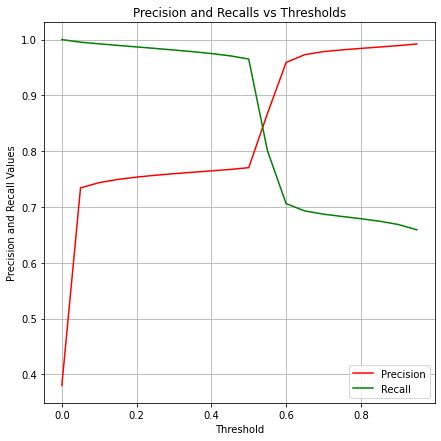

In [73]:
from pylab import rcParams

rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])